Importing Libraries and Data

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from platform import python_version
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import NuSVC
from sklearn.tree import ExtraTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
library = {
    "Pandas": pd,
    "Matplotlib": matplotlib,
    "Seaborn": sns,
    "NumPy": np,
    "Scikit-Learn": sklearn,
    }

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
df = pd.read_csv('/content/injury_data.csv')
df['Player_Weight'] = df['Player_Weight'].round(2)
df['Player_Height'] = df['Player_Height'].round(2)
df['Training_Intensity'] = df['Training_Intensity'].round(2)
df.head(5)

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
0,24,66.25,175.73,1,0.46,5,0
1,37,71.00,174.58,0,0.23,6,1
2,32,80.09,186.33,0,0.61,2,1
3,28,87.47,175.50,1,0.25,4,1
4,25,84.66,190.18,0,0.58,1,1


Checking Data

In [4]:
df_info = pd.DataFrame(df.dtypes, columns=['Dtype'])
df_info['Unique'] = df.nunique().values
df_info['Null'] = df.isnull().sum().values
df_info

,Dtype,Unique,Null
Player_Age,int64,22,0
Player_Weight,float64,863,0
Player_Height,float64,875,0
Previous_Injuries,int64,2,0
Training_Intensity,float64,101,0
Recovery_Time,int64,6,0
Likelihood_of_Injury,int64,2,0


In [5]:
with pd.option_context(
    "display.float_format",
    "{:.2f}".format,
    "display.max_columns",
    None,
):
    display(df.describe())

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,28.23,74.79,179.75,0.52,0.49,3.47,0.50
std,6.54,9.89,9.89,0.50,0.29,1.70,0.50
min,18.00,40.19,145.29,0.00,0.00,1.00,0.00
25%,22.00,67.95,173.03,0.00,0.24,2.00,0.00
50%,28.00,75.02,180.03,1.00,0.48,4.00,0.50
75%,34.00,81.30,186.56,1.00,0.73,5.00,1.00
max,39.00,104.65,207.31,1.00,1.00,6.00,1.00


Creating New Columns

In [6]:
df['BMI'] = df['Player_Weight'] / (df['Player_Height'] / 100) ** 2

gaps = [-float('inf'), 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
categories = ['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III']

df['BMI_Classification'] = pd.cut(df['BMI'], bins=gaps, labels=categories, right=False)

df.head(1)

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,BMI,BMI_Classification
0,24,66.25,175.73,1,0.46,5,0,21.453298,Normal


In [7]:
print('Player Age Min: {}'.format(df.Player_Age.min()))
print('Player Age Max: {}'.format(df.Player_Age.max()))

Player Age Min: 18
Player Age Max: 39


In [8]:
df["Age_Group"] = pd.cut(
    df["Player_Age"],
    bins=[18, 22, 26, 30, 34, df["Player_Age"].max()],
    labels=["18-22", "23-26", "27-30", "31-34", "35+"],
    include_lowest=True,
)
df.head(5)

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,BMI,BMI_Classification,Age_Group
0,24,66.25,175.73,1,0.46,5,0,21.453298,Normal,23-26
1,37,71.00,174.58,0,0.23,6,1,23.295357,Normal,35+
2,32,80.09,186.33,0,0.61,2,1,23.068148,Normal,31-34
3,28,87.47,175.50,1,0.25,4,1,28.399120,Overweight,27-30
4,25,84.66,190.18,0,0.58,1,1,23.407152,Normal,23-26


Exploratory Data Analysis

In [9]:
def plot_histogram_kde_and_boxplot(dataframe, column, color_column):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for ax in axs:
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(False)
    sns.histplot(data=dataframe, x=column, bins=20, color='skyblue', edgecolor='black', kde=True, ax=axs[0])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[0].set_title(f'{column} Histogram', weight='bold', size=13)
    sns.kdeplot(data=dataframe, x=column, color='skyblue', fill=True, hue=color_column, palette={0: 'green', 1: 'red'}, ax=axs[1])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title(f'{column} Density', weight='bold', size=13)
    sns.boxplot(data=dataframe[column], orient='h', ax=axs[2])
    axs[2].set_xlabel('')
    axs[2].set_ylabel('')
    axs[2].set_title(f'{column} Boxplot', weight='bold', size=13)
    plt.tight_layout()
    plt.show()
def plot_dual_chart(dataframe, column1, column2, cat_order=None, y_limit1=None, y_limit2=None):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    for ax in axs:
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(False)
    sns.histplot(data=dataframe, x=column1, bins=20, color='skyblue', edgecolor='black', kde=True, ax=axs[0])
    axs[0].set_title(f'{column1} Histogram', weight='bold', size=13)
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    if y_limit1 is None:
        y_limit1 = dataframe[column1].max() * 1.1
    axs[0].set_ylim(top=y_limit1)
    ax = sns.countplot(data=dataframe, x=column2, hue='Likelihood_of_Injury', palette={0: 'green', 1: 'red'}, ax=axs[1], linewidth=2, order=cat_order)
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title(f'{column2} x Likelihood_of_Injury', weight='bold', size=13)
    axs[1].tick_params(axis='x', rotation=0)
    axs[1].grid(False)
    axs[1].legend()
    if y_limit2 is None:
        y_limit2 = dataframe[column2].value_counts().max() * 1.1
    axs[1].set_ylim(top=y_limit2)
    for p in axs[1].patches:
        height = p.get_height()
        if not np.isnan(height):
            axs[1].annotate(str(int(height)), (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', color='black', weight='bold', size=13)
        else:
            axs[1].annotate("0", (p.get_x() + p.get_width() / 2., 0),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', color='black', weight='bold', size=13)
    plt.tight_layout()
    plt.show()

Age_Group

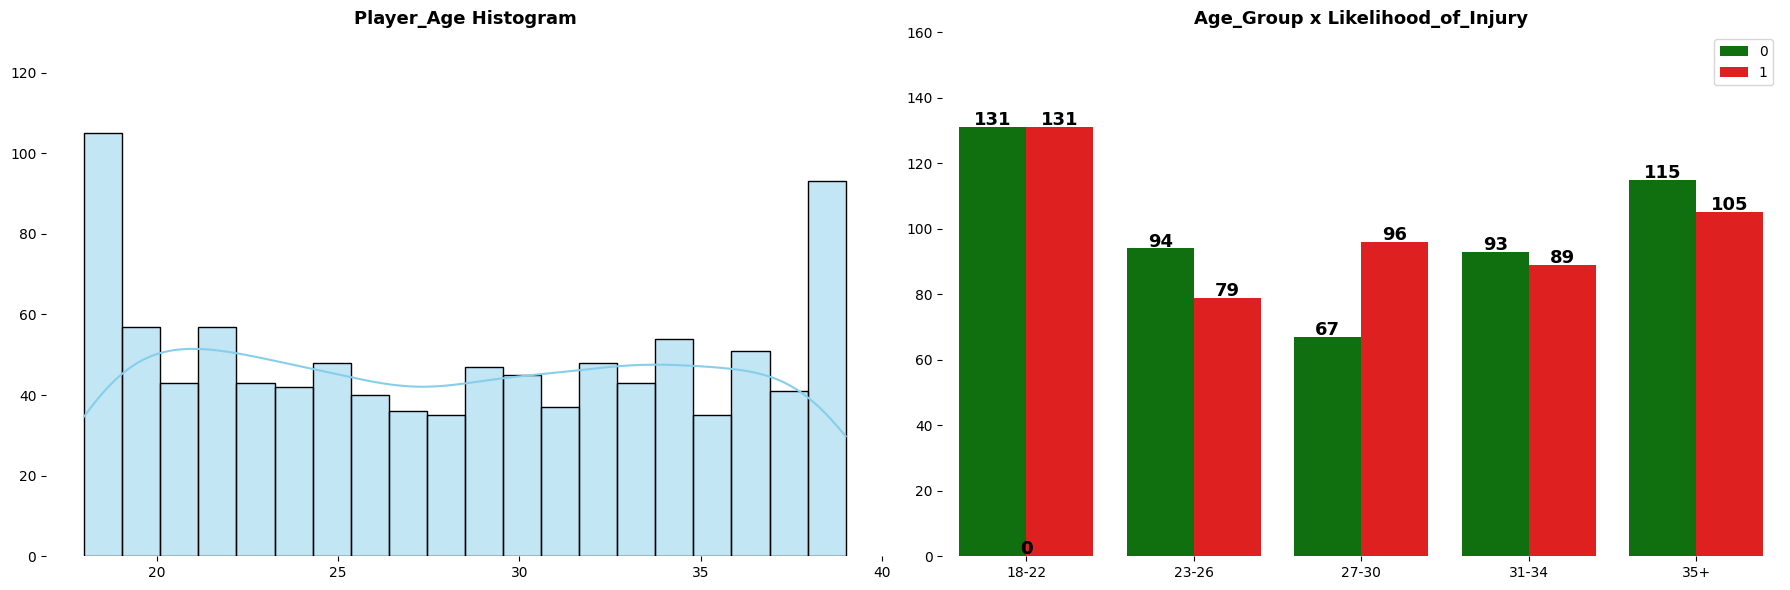

In [10]:
plot_dual_chart(df, 'Player_Age', 'Age_Group', cat_order=["18-22", "23-26", "27-30", "31-34", "35+"], y_limit1=130, y_limit2=160)

BMI_Classification

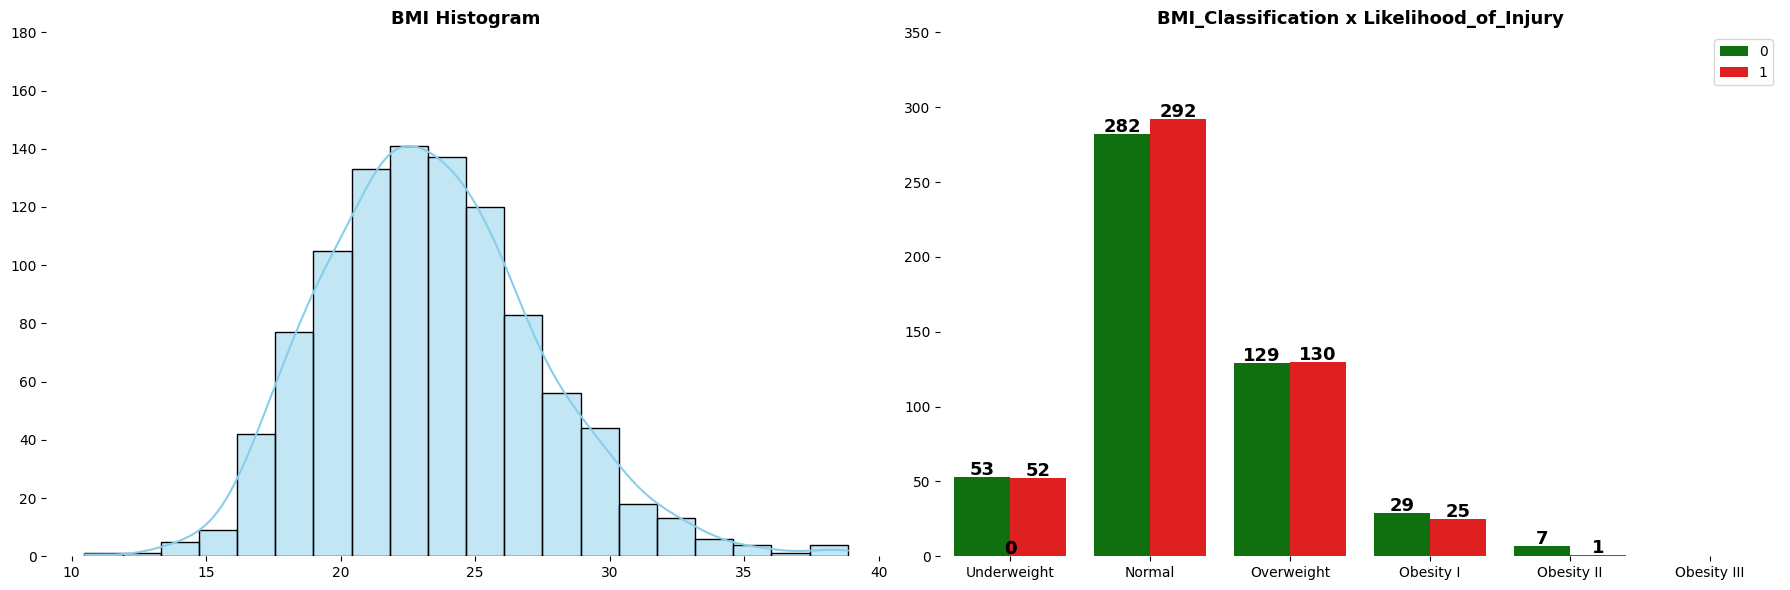

In [11]:
plot_dual_chart(df, 'BMI', 'BMI_Classification', y_limit1=180, y_limit2=350)

Player_Weight

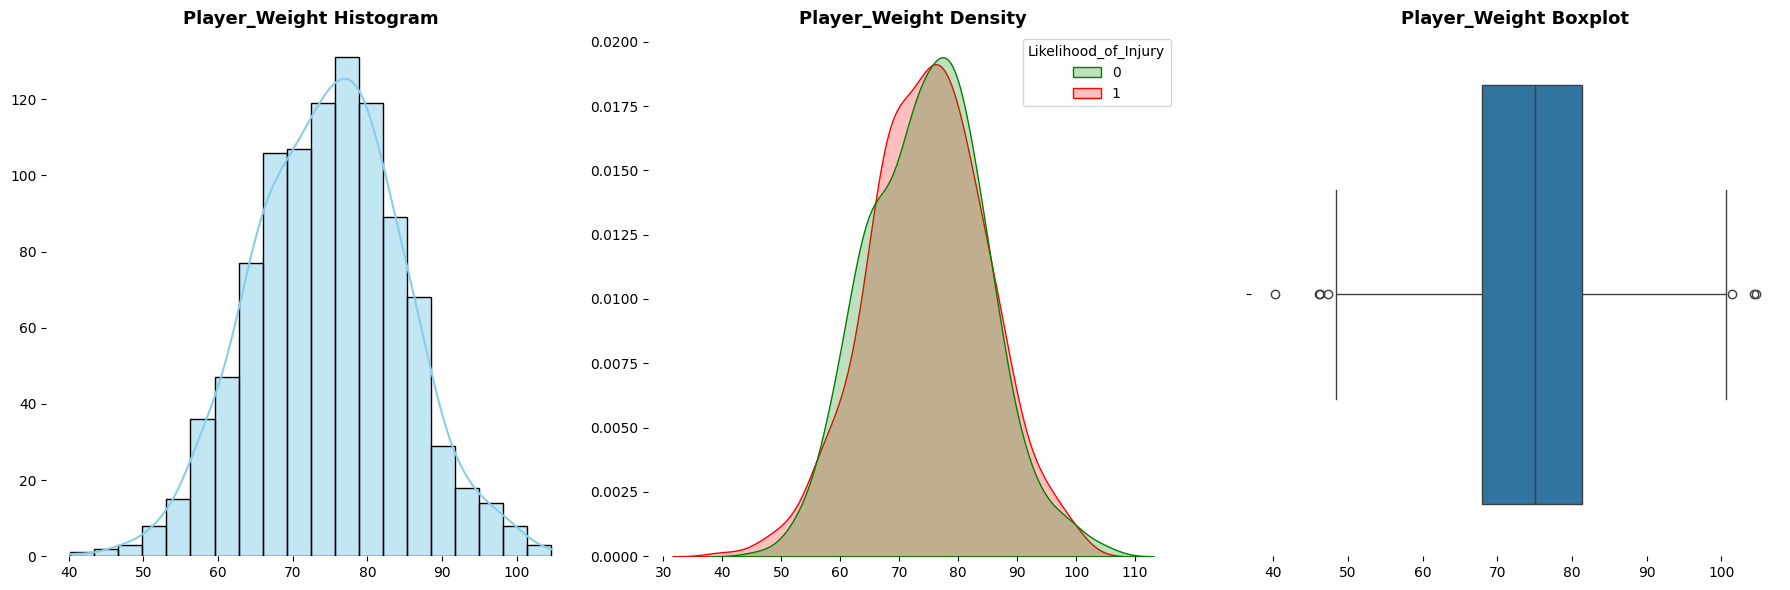

In [12]:
plot_histogram_kde_and_boxplot(df, 'Player_Weight', 'Likelihood_of_Injury')

Player_Height

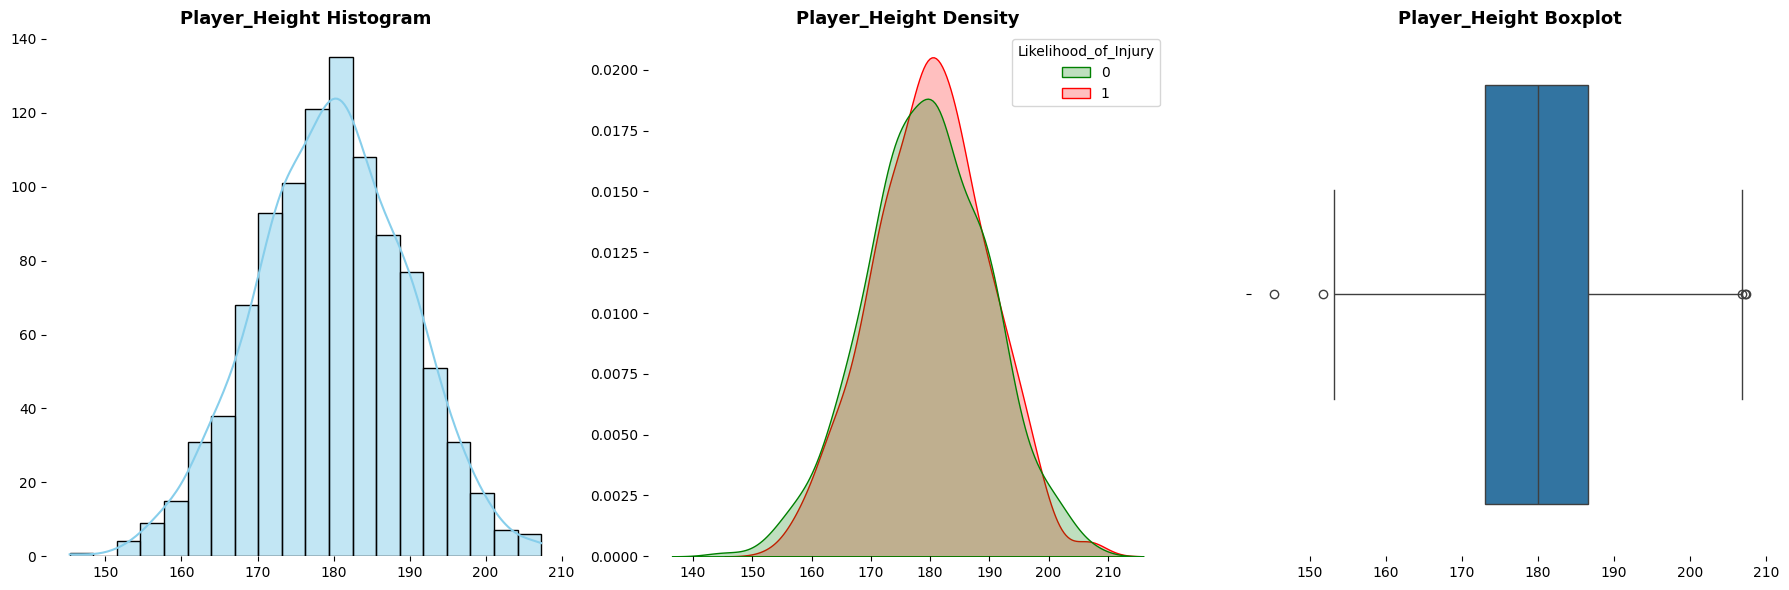

In [13]:
plot_histogram_kde_and_boxplot(df, 'Player_Height', 'Likelihood_of_Injury')

Training_Intensity

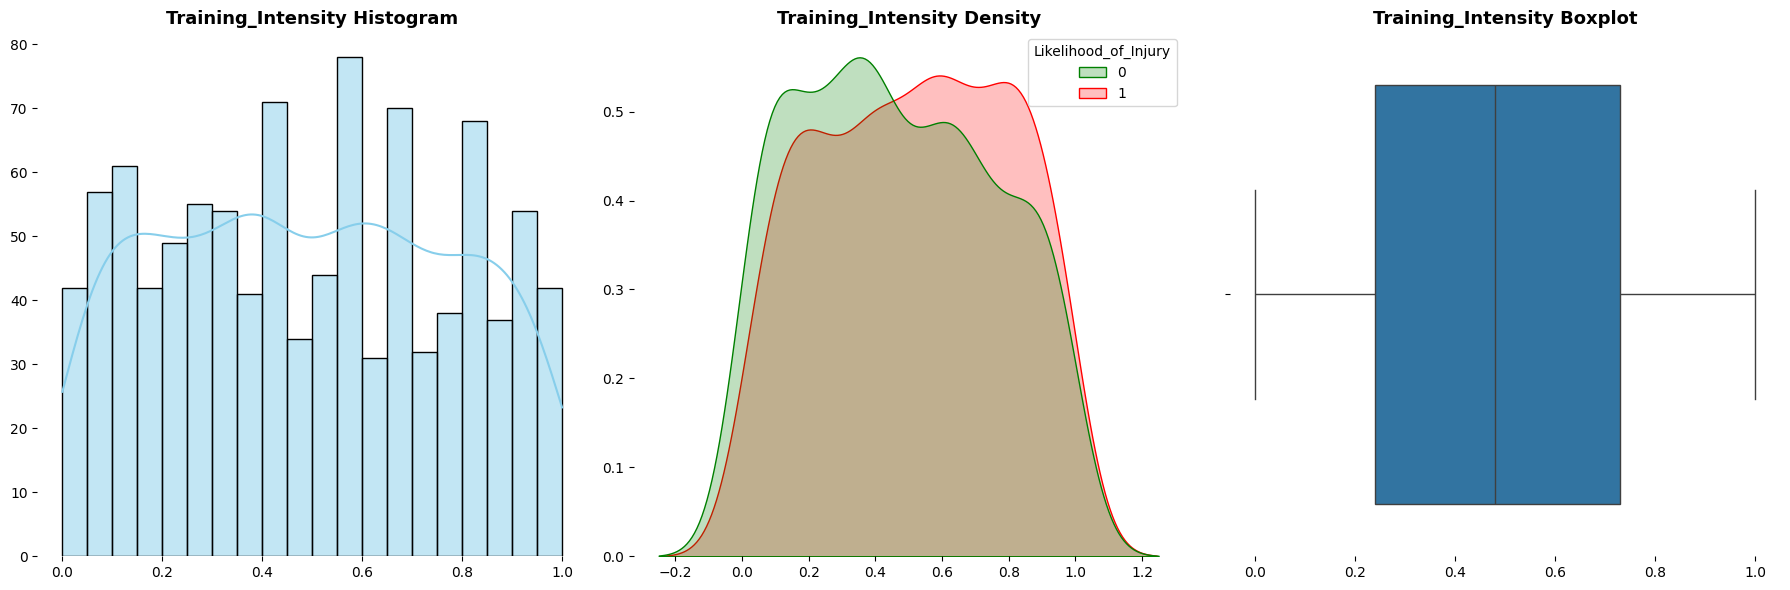

In [14]:
plot_histogram_kde_and_boxplot(df, 'Training_Intensity', 'Likelihood_of_Injury')

Recovery_Time

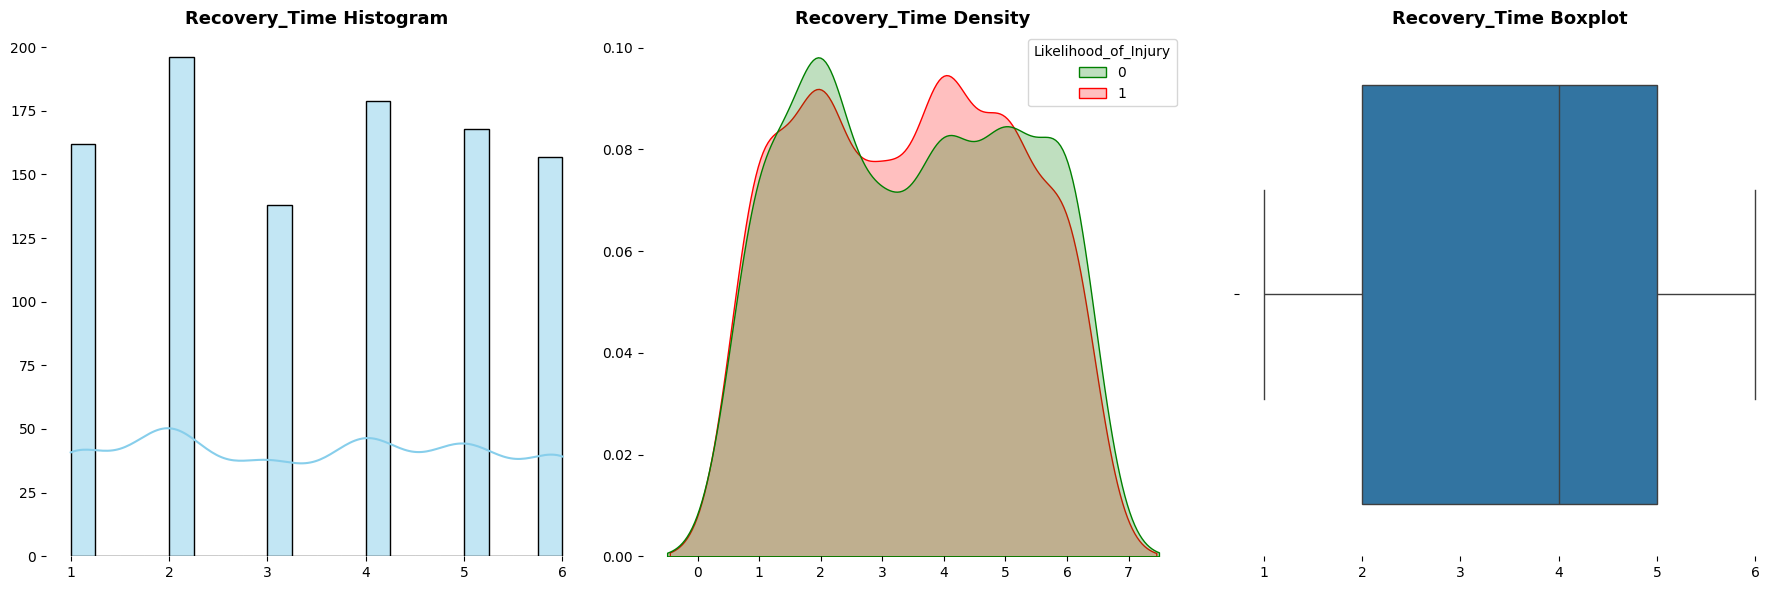

In [15]:
plot_histogram_kde_and_boxplot(df, 'Recovery_Time', 'Likelihood_of_Injury')

Previous_Injuries

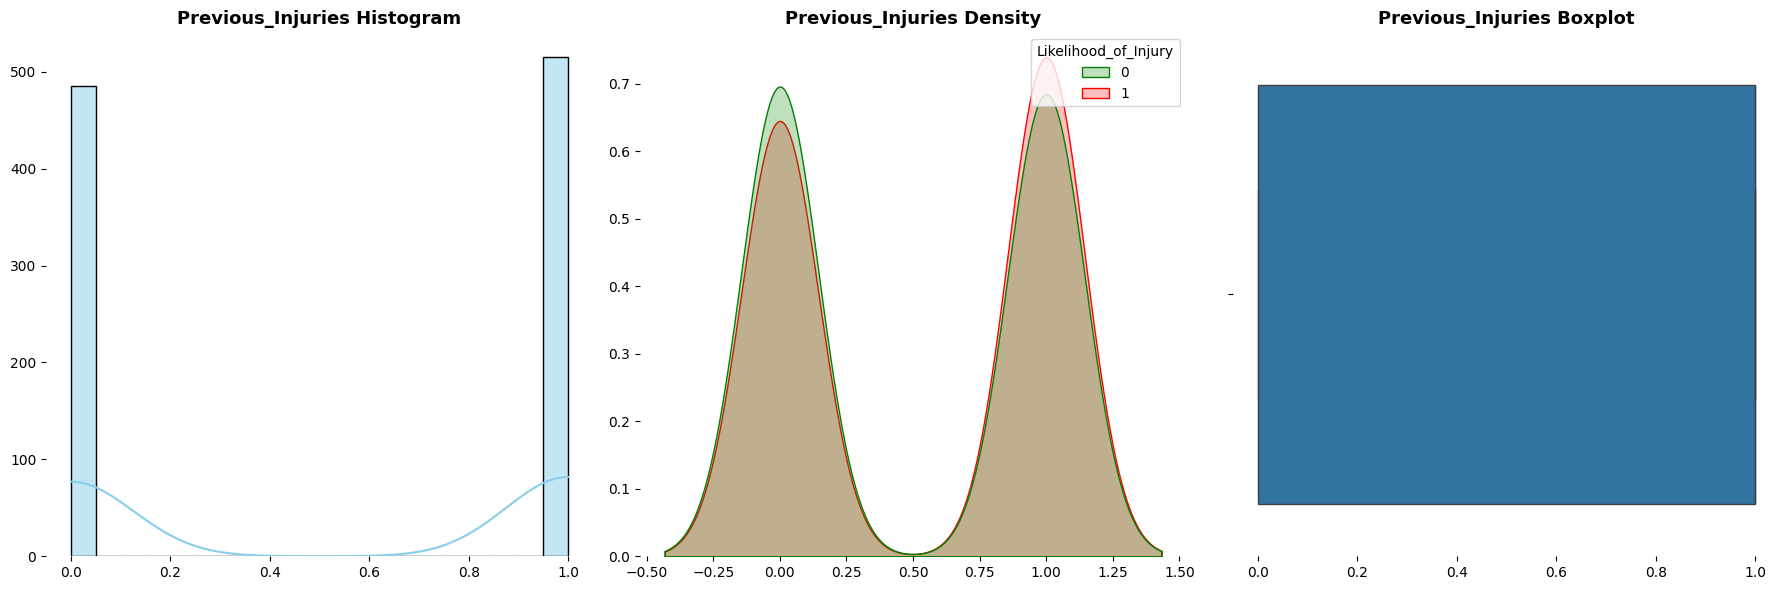

In [16]:
plot_histogram_kde_and_boxplot(df, 'Previous_Injuries', 'Likelihood_of_Injury')

Likelihood_of_Injury

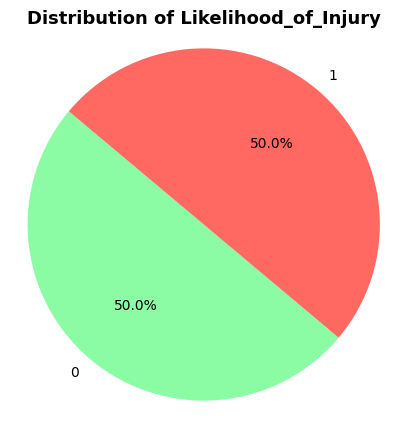

In [17]:
li_count = df['Likelihood_of_Injury'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(li_count, labels=li_count.index, autopct='%1.1f%%', startangle=140, colors=['#8CFCA4', '#FF6961'])
plt.title('Distribution of Likelihood_of_Injury', weight='bold', size=13)
plt.axis('equal')
plt.show()

Data Preprocessing

In [18]:
one_hot_cols = [
    "BMI_Classification",
    "Age_Group",
]
df_categorical = df[one_hot_cols]
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df_categorical)
one_hot_feature_names = encoder.get_feature_names_out(one_hot_cols)
df_encoded = pd.DataFrame(encoded_data.toarray(), columns=one_hot_feature_names)
df_final = pd.concat([df, df_encoded], axis=1)
df_final.drop(columns=['BMI_Classification', 'Age_Group'], inplace=True)
df_final.head()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,BMI,BMI_Classification_Normal,BMI_Classification_Obesity I,BMI_Classification_Obesity II,BMI_Classification_Overweight,BMI_Classification_Underweight,Age_Group_18-22,Age_Group_23-26,Age_Group_27-30,Age_Group_31-34,Age_Group_35+
0,24,66.25,175.73,1,0.46,5,0,21.453298,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,37,71.00,174.58,0,0.23,6,1,23.295357,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,32,80.09,186.33,0,0.61,2,1,23.068148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,28,87.47,175.50,1,0.25,4,1,28.399120,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,25,84.66,190.18,0,0.58,1,1,23.407152,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Correlation Between Columns

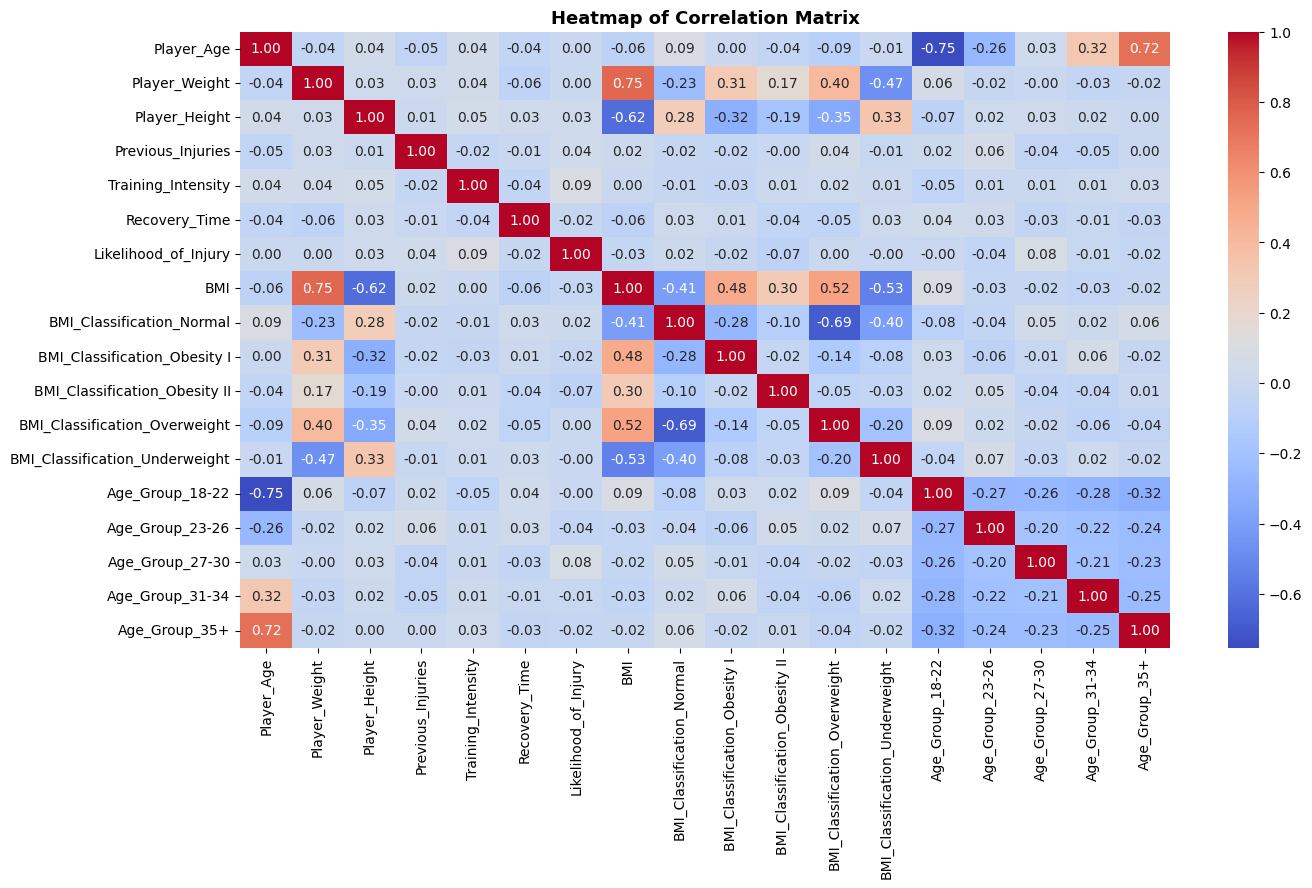

In [19]:
correlation_matrix = df_final.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Matrix', weight='bold', size=13)
plt.show()

Correlation with 'Likelihood_of_Injury

<ipython-input-20-d7d77fa7bbe1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_likelihood.index, y=correlation_with_likelihood.values, palette='coolwarm')


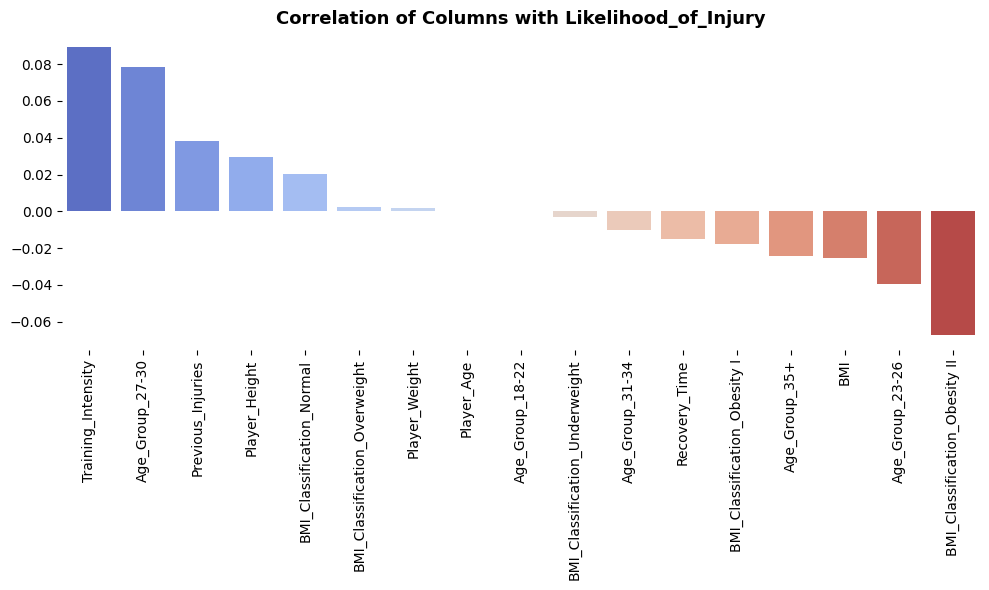

In [20]:
correlation_matrix = df_final.corr()
correlation_with_likelihood = correlation_matrix['Likelihood_of_Injury']
correlation_with_likelihood = correlation_with_likelihood.drop('Likelihood_of_Injury')
correlation_with_likelihood = correlation_with_likelihood.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_likelihood.index, y=correlation_with_likelihood.values, palette='coolwarm')
plt.xticks(rotation=90, ha='center')
plt.xlabel('')
plt.ylabel('')
plt.box(False)
plt.title('Correlation of Columns with Likelihood_of_Injury', weight='bold', size=13)
plt.tight_layout()
plt.show()

In [21]:
df_final = df_final.loc[:, ~df_final.columns.str.startswith('Age_Group')]
df_final = df_final.drop(columns=['BMI'])
df_final.head(1)

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,BMI_Classification_Normal,BMI_Classification_Obesity I,BMI_Classification_Obesity II,BMI_Classification_Overweight,BMI_Classification_Underweight
0,24,66.25,175.73,1,0.46,5,0,1.0,0.0,0.0,0.0,0.0


Training Models

In [22]:
X = df_final.drop('Likelihood_of_Injury', axis=1)
y = df_final['Likelihood_of_Injury']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [23]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
models = {
    "LGBMClassifier": LGBMClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(),
    "NuSVC": NuSVC(probability=True),
    "ExtraTreeClassifier": ExtraTreeClassifier(),
    }
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    recall = recall_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    print(f"Model: {model_name}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print("-" * 50)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 441, number of negative: 459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 900, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490000 -> initscore=-0.040005
[LightGBM] [Info] Start training from score -0.040005
Model: LGBMClassifier
Recall: 0.5423728813559322
Accuracy: 0.61
Precision: 0.7272727272727273
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoostClassifier
Recall: 0.576271186440678
Accuracy: 0.6
Precision: 0.6938775510204082
--------------------------------------------------
Model: ExtraTreesClassifier
Recall: 0.559322033898305
Accuracy: 0.61
Precision: 0.717391304347826
--------------------------------------------------
Model: NuSVC
Recall: 0.8135593220338984
Accuracy: 0.59
Precision: 0.6153846153846154
--------------------------------------------------
Model: ExtraTreeClassifier
Recall: 0.5084745762711864
Accuracy: 0.53
Precision: 0.625
--------------------------------------------------


Model Selection


In a real-life scenario where the outcome of this model could assist a
coaching staff in deciding whether or not to field a player based on the probability of them sustaining an injury during the game, I would opt for the model with the lowest incidence of False Negatives. This way, the player's health and physical condition would be preserved by reducing the possibility of them participating in a game wrongly identified by the model as not posing a risk of injury.

Considering this situation, We will choose to use the recall score to select the best model, as this metric is penalized whenever a false negative is predicted.

Finally, We will plot the confusion matrices and the ROC curve to reinforce the selection of the model that best minimizes the risk of false negatives.




Confusion Matrix

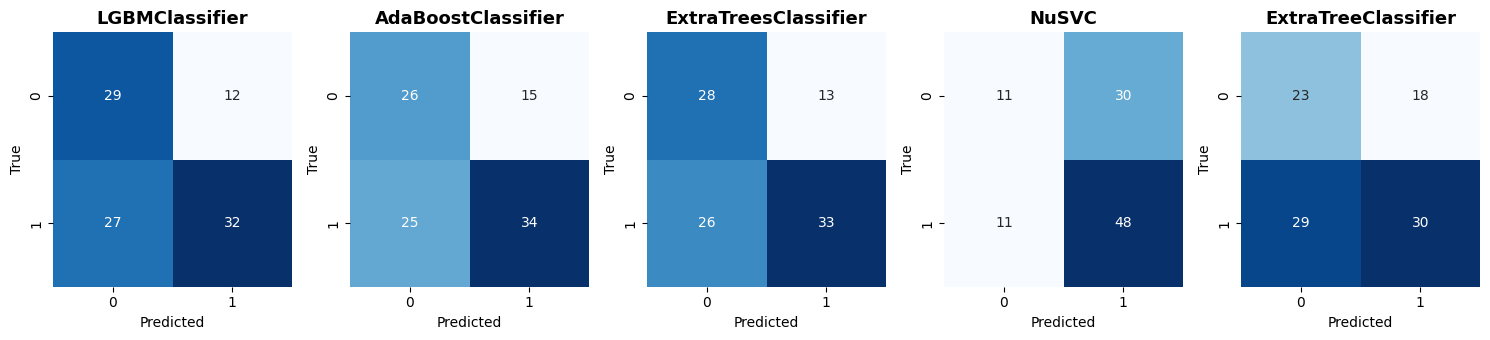

In [24]:
fig, axes = plt.subplots(1, len(models), figsize=(15, 3.5))
for ax, (model_name, model) in zip(axes, models.items()):
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"{model_name}", weight='bold', size=13)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

Inverted ROC Curve

The inverted ROC curve is useful when the analysis focuses on the negative class rather than the positive class. It provides insight into the model's ability to avoid misclassifying negative instances.

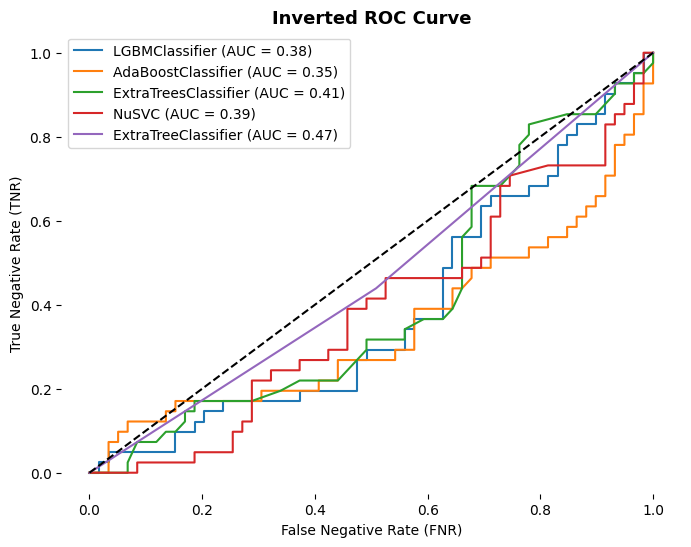

In [25]:
plt.figure(figsize=(8, 6))
for model_name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 0]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    tnr = 1 - fpr
    fnr = 1 - tpr
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fnr, tnr, label=f'{model_name} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Negative Rate (FNR)')
plt.ylabel('True Negative Rate (TNR)')
plt.title('Inverted ROC Curve', weight='bold', size=13)
plt.legend()
plt.box(False)
plt.show()

Based on the Recall value obtained, as well as the visualization of the Confusion Matrix and the ROC curve, the chosen model is NuSVC.

The End